# A Stochastic Gradient Descent (SGD) algorithm in Julia
Supports the following features: 
* arbitrary number of hidden layers
* mini-batch
* ReLU 
* dropconnect
* learning curves
* SGD
* learning rate
* momentum

##loading data

In [1]:
using MNIST # hand written digits

trainX, trainY = traindata();
testX, testY = testdata();

# limit the dataset for demonstration purpose
trainX = trainX[:,1:5000]
trainY = trainY[1:5000]

testX = testX[:,1:1000]
testY = testY[1:1000]

trainY = round(Int, trainY) + 1 # convert to integer and allow indexing later
testY = round(Int, testY) + 1 # convert to integer and allow indexing later

print("Number of features: ", size(trainX,1), " (28x28 grey scale image)")
print("\n")
print("Number of training examples: ", size(trainX,2))
print("\n")
print("Number of testing examples: ", size(testX,2))

Number of features: 784 (28x28 grey scale image)
Number of training examples: 5000
Number of testing examples: 1000

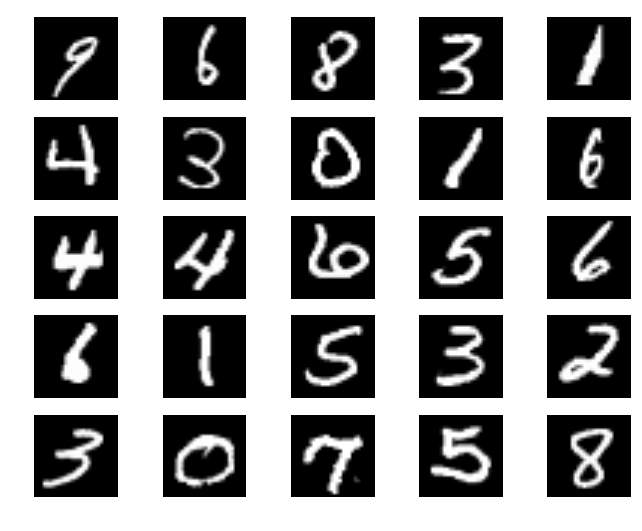

In [2]:
# display random images from the training set
using PyPlot;

for i = 1:25
    PyPlot.subplot(5,5,i)
    PyPlot.axis("off")
    PyPlot.imshow(reshape(trainX'[rand(1:size(trainX',1)),:],28,28), cmap=PyPlot.ColorMap("gray"))
end

##adding bias

In [ ]:
m = size(trainX,2) # number of training examples
X = trainX'
y = trainY'
a1 = [ones(m, 1) X] # adding bias units set to 1

mtest = size(testX,2) # number of testing examples
Xtest = testX'
ytest = testY'
a1test = [ones(mtest, 1) Xtest] # adding bias units set to 1

##model

In [4]:
input_layer_size = size(X,2) #input layer size
hidden_layer_size = [20 20] # number of hidden layers and their size
num_labels = 10 # output layer, number of digits for classification, 0-9
layers = [input_layer_size hidden_layer_size num_labels]

lambda = 0 # regularization parameter
iterations = 100
dropout = 0.0 # value between 0 and 1, 0 => no dropout
mbatch = m # minibatch size, 1 => stochastic and m => batch, should be a factor of m
learning_rate = 1e-6
momentum = 0.9

# randomly initialize weights
epsilon_init = 0.12;
ThetaCollection = Array(Array{Float64}, length(layers)-1)
for i = 1:length(ThetaCollection)
    ThetaCollection[i] = rand(layers[i+1],layers[i]+1) * 2 * epsilon_init - epsilon_init;
    row,col = size(ThetaCollection[i])
    println("Theta$i has     ", row," rows,     ", col, " cols,     ", row*col, " elements")
end

Theta = []
for i = 1:length(ThetaCollection)
    Theta = vcat(Theta, ThetaCollection[i][:])
end

# prepare target for multiclass classification
Y = zeros(m,num_labels)
for i = 1:m
    Y[i, y[i]] = 1
end

Ytest = zeros(mtest,num_labels)
for i = 1:mtest
    Ytest[i, ytest[i]] = 1
end

Theta1 has     20 rows,     785 cols,     15700 elements
Theta2 has     20 rows,     21 cols,     420 elements
Theta3 has     10 rows,     21 cols,     210 elements


In [5]:
zigmoid(z) = max(0, z) # ReLU

zigmoid (generic function with 1 method)

In [6]:
gizmoid(z) =  z .> 0 # derivative of ReLU

gizmoid (generic function with 1 method)

In [7]:
zigmoidout(z) =  1.0 ./ (1.0 + exp(-z)) # sigmoid function for the output layer

zigmoidout (generic function with 1 method)

##training

In [ ]:
lenz = length(ThetaCollection) # number of layers
z = Array(Array{Float64}, lenz) # inputs to layers
a = Array(Array{Float64}, lenz) # activation of layers
ztest = Array(Array{Float64}, lenz)
atest = Array(Array{Float64}, lenz)
delta = Array(Array{Float64}, lenz) # errors of layers
Theta_grad = Array(Array{Float64}, lenz) # gradients of weights
ThetaCurrent = zeros(size(Theta)) # weights at iteration n
ThetaPrevious = zeros(size(Theta)) # weights at iteration n+1

# preparing binary mask for dropout
using Distributions
binarymask = Array(Array{Float64}, lenz-1)

# preparing data for looping within the cost function
mtrain = m
a1train = a1
Ytrain = Y
batchscale = mtrain/mbatch

# cost function and gradient calculation 
@time for iterate = 1:iterations
J = 0
Jtest = 0
grad = zeros(size(Theta)) 
a1train = a1train[rand(1:mtrain, mtrain), :]

ThetaPrevious = ThetaCurrent
ThetaCurrent = Theta

    for batch = 1:mbatch:mtrain # begin loop over minibatches
        a1 = a1train[batch:batch+(mbatch-1),:]
        m = size(a1,1)
        Y = Ytrain[batch:batch+(mbatch-1),:]
        
        totElements = 0
        thetaSqSum = 0
        for i = 1:length(ThetaCollection)
            row,col = size(ThetaCollection[i])
            ThetaCollection[i] = reshape(Theta[totElements+1:totElements+row*col], row, col)
            totElements += row*col
            thetaSqSum += sum(ThetaCollection[i][:,2:end].^2)
            if(i != lenz) 
                binarymask[i] = rand(Binomial(1, (1-dropout)), row, col)                
            end          
        end
        
        # forward pass - train            
        atemp = a1        
        for i = 1:lenz
            if(i!=lenz)
                z[i] = *(ThetaCollection[i] .* binarymask[i], atemp')
                z[i] = vcat(ones(1,m), z[i]) 
                a[i] = zigmoid(z[i]')
                atemp = a[i]
            else
                z[i] = *(ThetaCollection[i], atemp')
                a[i] = zigmoidout(z[i]')
            end
        end   
    
        J +=  1/m * (sum((-Y .* log(a[lenz]))  -   ((1 - Y) .* (log(1 - a[lenz])))) + (lambda/2 * thetaSqSum))
        
        # forward pass - test            
        atemp = a1test
    for i = 1:lenz
        if(i!=lenz)
                ztest[i] = *(ThetaCollection[i] .* binarymask[i], atemp')
                ztest[i] = vcat(ones(1,mtest), ztest[i]) 
                atest[i] = zigmoid(ztest[i]')
                atemp = atest[i]
        else
                ztest[i] = *(ThetaCollection[i], atemp')
                atest[i] = zigmoidout(ztest[i]')
        end
    end   
    
        Jtest +=  1/mtest * (sum((-Ytest .* log(atest[lenz]))  -   ((1 - Ytest) .* (log(1 - atest[lenz])))) + (lambda/2 * thetaSqSum));
        
        
        # backpropagation             
        for i = sort([1:lenz], rev=true)
            if(i==lenz)
                delta[i] = a[i]' - Y'  
            elseif(i==lenz-1)
                delta[i] = *(ThetaCollection[i+1]', delta[i+1]).*gizmoid(z[i])
            else
                delta[i] = *(ThetaCollection[i+1]', delta[i+1][2:end,:]).*gizmoid(z[i])
            end
        end

        for i = sort([1:lenz], rev=true)
            if(i==lenz) 
                Theta_grad[i] = *(delta[i],a[i-1])  
            elseif(i==1)
                Theta_grad[i] = *(delta[i][2:end,:],a1) .* binarymask[i]
            else
                Theta_grad[i] = *(delta[i][2:end,:],a[i-1]) .* binarymask[i]
            end
        end                        
    
        for i = sort([1:lenz], rev=true)
            Theta_grad[i] = Theta_grad[i]/m + (lambda/m)* hcat(zeros(size(ThetaCollection[i], 1), 1), ThetaCollection[i][:,2:end])
        end    
    
        tmpgrad = zeros(0)
        
        for i = 1:lenz
            tmpgrad = vcat(tmpgrad, Theta_grad[i][:])        
        end
        
        grad += tmpgrad
        
    end # end loop over minibatches   
    
        
    Theta = ThetaCurrent - (learning_rate * grad/batchscale) + momentum*(ThetaCurrent-ThetaPrevious)

   if(iterate%20 == 0) 
        PyPlot.scatter(iterate,J/batchscale, label="train", color="blue")
        PyPlot.scatter(iterate,Jtest/batchscale, label="test", color="green")
        #PyPlot.legend()
        IJulia.clear_output(true)
        IJulia.display(PyPlot.gcf())
        println(iterate, " ", J/batchscale, " ", learning_rate);         
    end

end

##inference

In [ ]:
# prediction

# number of samples to be drawn as required by dropconnect
if(dropout == 0)
    dropout_samples = 1
else
    dropout_samples = 1000
end

dropout_samplemean = Array(Array{Float64}, lenz-1)

function predict(Theta)
    totElements = 0
    thetaSqSum = 0
    for i = 1:length(ThetaCollection)
        row,col = size(ThetaCollection[i])
        ThetaCollection[i] = reshape(Theta[totElements+1:totElements+row*col], row, col)
        totElements += row*col
        thetaSqSum += sum(ThetaCollection[i][:,2:end].^2)
    end

    ### Training ###
    atemp = a1test        
    for i = 1:lenz
        if(i!=lenz)
            mean = *(ThetaCollection[i], atemp') * (1-dropout)          
            var = *(ThetaCollection[i].^2, atemp'.^2) * (1-dropout)*(dropout)
            dropout_samplemean[i] = zeros(size(mean))
            dropout_samplemean[i] = dropout_samplemean[i][:]
            for sample = 1:dropout_samples
                pdmat = MvNormal(mean[:], var[:])
                dropout_samplemean[i] += pdmat.μ
            end
            dropout_samplemean[i] /= dropout_samples
            z[i] = reshape(dropout_samplemean[i], size(*(ThetaCollection[i], atemp')))
            z[i] = vcat(ones(1,mtest), z[i])
            a[i] = zigmoid(z[i]')
            atemp = a[i]
        else
            z[i] = *(ThetaCollection[i], atemp')
            a[i] = zigmoidout(z[i]')
        end
    end            

    val, p = findmax(a[lenz]', 1)
    println("Prediction accuracy on test set is ",(sum(p%10 .== ytest%10) /mtest)*100, "%")
end

predict(Theta)